In [1]:
import tensorflow
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Embedding, Dense, Dropout,Lambda, Flatten,Activation
from tensorflow.keras.layers import BatchNormalization,Input,LeakyReLU
from tensorflow.keras.backend import abs,sqrt,sum,maximum,square,epsilon
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from scipy.spatial.distance import cosine

import os
import numpy as np
import tqdm
import pandas as pd
import itertools


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder


import re
import nltk
#nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer #tokanization and removel of punctuation 


import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/home/umar_visionx/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/umar_visionx/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/umar_visionx/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/umar_visionx/anaconda3/lib/python3.7/site-packages/tensorf

In [2]:
#removing special character and numbers
def rem_sp_char(words):
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]'  # defined pattern to keep
    words=re.sub(pattern, '', words)
    return words

#tokanizing and removing punctuations
def remove_punct(words):
  tokenizer = RegexpTokenizer(r'\w+')
  tokens=tokenizer.tokenize(words)
  return tokens

#lemmitization
def lemmitizar(words):
  lemmatized_words=[]
  l = WordNetLemmatizer()
  for word in words:
      token = l.lemmatize(word)
      lemmatized_words.append(token)
  return lemmatized_words

#removing stop-words
def remove_stopwords(words):
  filter_words = []
  Stopwords = stopwords.words('english')
  for word in words:
      if word not in Stopwords:
          filter_words.append(word)
  return filter_words

#converting to lowercase
def lower_case(words):
  lower_words=[]
  for word in words:
    lower_words.append(word.lower())
  return lower_words


In [3]:
data_path='/media/umar_visionx/Backup Plus/Active/Faizan/dataset'
#data_path='/media/umar_visionx/Backup Plus/Active/Faizan/test_dataset'

In [4]:
#making dictionaries and lists of text and labels
data_dict={}
#txt_file_path=[]
labels=[]
text=[]
for clss in os.listdir(data_path):
 clss_path=os.path.join(data_path,clss)
 for txt_file in os.listdir(clss_path):
    file_path=os.path.join(clss_path,txt_file)
    #reading text file
    with open(file_path, "r") as file:
        para = file.read().rstrip('\n')#rstrip method removes trailing character based on string argument passed

        #apply preprocessing functions on para
        words = rem_sp_char(para) #removing special character and numbers
        tokens = remove_punct(words) #removing punctuations and tokanization
        tokens = lemmitizar(tokens) #lemmitization
        tokens = remove_stopwords(tokens) ##removing stop-words
        tokens = lower_case(tokens) #converting to lowercase

        #joining words with space and removing single tetter tokens
        parag=' '.join( [word for word in tokens if len(word)>1] )
        #parag=' '.join( [word for word in tokens if len(word)>1 and word.isalpha()] )#if we dont want numeric values


        #inseting data into lists and dictionaries
        text.append(parag)
        #text_file_path.append(file_path)
        labels.append(clss)
        data_dict[parag]=clss


In [5]:
print(len(text))
print(len(labels))
print(len(data_dict))

11660
11660
11212


In [6]:
df= pd.DataFrame()
df["text"]=text
df["target"]=labels

df.head()

,text,target
0,29 2021 10 42 alberta health services rrduser ...,Admin Note
1,30 2021 09 34 alberta health services rrduser ...,Admin Note
2,29 2021 11 03 alberta health services rrduser ...,Admin Note
3,2021 08 25 alberta health services rrduser 403...,Admin Note
4,ahs 2021 23 05 am page alberta health services...,Admin Note


In [7]:
#Label Encoding
encoder=LabelEncoder()

encoder.fit(list(df.target))
print(f"Unique Labels:   {list(encoder.classes_)}")

label=encoder.transform(list(df.target))
print()
print(f"Encoded Labels: {label} ")

Unique Labels:   ['Admin Note', 'Clinical History And Summary', 'Consult Note', 'Cover Page', 'Imaging Note', 'Insurance Authorization', 'Intake Forms', 'Lab Test', 'Other', 'Patient Profile', 'Prescriptions', 'Referral Letter', 'Requisition Form']

Encoded Labels: [ 0  0  0 ... 12 12 12] 


In [8]:
#Adding encoded labels to the dataframe
df["labels"]=label

df.head()

,text,target,labels
0,29 2021 10 42 alberta health services rrduser ...,Admin Note,0
1,30 2021 09 34 alberta health services rrduser ...,Admin Note,0
2,29 2021 11 03 alberta health services rrduser ...,Admin Note,0
3,2021 08 25 alberta health services rrduser 403...,Admin Note,0
4,ahs 2021 23 05 am page alberta health services...,Admin Note,0


In [9]:
#removing extra column
df = df.drop('target', 1)
df.head()

,text,labels
0,29 2021 10 42 alberta health services rrduser ...,0
1,30 2021 09 34 alberta health services rrduser ...,0
2,29 2021 11 03 alberta health services rrduser ...,0
3,2021 08 25 alberta health services rrduser 403...,0
4,ahs 2021 23 05 am page alberta health services...,0


In [10]:
print(f"Unique Labels after Encoding:  {df.labels.unique()}")

Unique Labels after Encoding:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


In [11]:
#making separate lists of taxt that has common labels
lst_0 = list(df[df['labels']==0]['text'])
lst_1 = list(df[df['labels']==1]['text'])
lst_2 = list(df[df['labels']==2]['text'])
lst_3 = list(df[df['labels']==3]['text'])
lst_4 = list(df[df['labels']==4]['text'])
lst_5 = list(df[df['labels']==5]['text'])
lst_6 = list(df[df['labels']==6]['text'])
lst_7 =list(df[df['labels']==7]['text'])
lst_8 = list(df[df['labels']==8]['text'])
lst_9 = list(df[df['labels']==9]['text'])
lst_10 = list(df[df['labels']==10]['text'])
lst_11 = list(df[df['labels']==11]['text'])
lst_12 = list(df[df['labels']==12]['text'])

In [12]:
print(len(lst_0))
print(len(lst_1))
print(len(lst_2))
print(len(lst_3))
print(len(lst_4))
print(len(lst_5))
print(len(lst_6))
print(len(lst_7))
print(len(lst_8))
print(len(lst_9))
print(len(lst_10))
print(len(lst_11))
print(len(lst_12))

588
1045
1438
1542
491
969
23
780
982
72
55
2363
1312


In [13]:
#adding remaining sample to negitive samples list list so that we can make pairs with positive and negitive samples
lst_0_neg= list(itertools.chain(lst_1,lst_2,lst_3,lst_4,lst_5,lst_6,lst_7,lst_8,lst_9,lst_10,lst_11,lst_12))
lst_1_neg= list(itertools.chain(lst_0,lst_2,lst_3,lst_4,lst_5,lst_6,lst_7,lst_8,lst_9,lst_10,lst_11,lst_12))
lst_2_neg= list(itertools.chain(lst_0,lst_1,lst_3,lst_4,lst_5,lst_6,lst_7,lst_8,lst_9,lst_10,lst_11,lst_12))
lst_3_neg= list(itertools.chain(lst_0,lst_1,lst_2,lst_4,lst_5,lst_6,lst_7,lst_8,lst_9,lst_10,lst_11,lst_12))
lst_4_neg= list(itertools.chain(lst_0,lst_1,lst_2,lst_3,lst_5,lst_6,lst_7,lst_8,lst_9,lst_10,lst_11,lst_12))
lst_5_neg= list(itertools.chain(lst_0,lst_1,lst_2,lst_3,lst_4,lst_6,lst_7,lst_8,lst_9,lst_10,lst_11,lst_12))
lst_6_neg= list(itertools.chain(lst_0,lst_1,lst_2,lst_3,lst_4,lst_5,lst_7,lst_8,lst_9,lst_10,lst_11,lst_12))
lst_7_neg= list(itertools.chain(lst_0,lst_1,lst_2,lst_3,lst_4,lst_5,lst_6,lst_8,lst_9,lst_10,lst_11,lst_12))
lst_8_neg= list(itertools.chain(lst_0,lst_1,lst_2,lst_3,lst_4,lst_5,lst_6,lst_7,lst_9,lst_10,lst_11,lst_12))
lst_9_neg= list(itertools.chain(lst_0,lst_1,lst_2,lst_3,lst_4,lst_5,lst_6,lst_7,lst_8,lst_10,lst_11,lst_12))
lst_10_neg= list(itertools.chain(lst_0,lst_1,lst_2,lst_3,lst_4,lst_5,lst_6,lst_7,lst_8,lst_9,lst_11,lst_12))
lst_11_neg= list(itertools.chain(lst_0,lst_1,lst_2,lst_3,lst_4,lst_5,lst_6,lst_7,lst_8,lst_9,lst_10,lst_12))
lst_12_neg= list(itertools.chain(lst_0,lst_1,lst_2,lst_3,lst_4,lst_5,lst_6,lst_7,lst_8,lst_9,lst_10,lst_11))


In [43]:
#making a pandas dataframe
columns=['text1', 'text2', 'label']
d_frame = pd.DataFrame(columns=columns)
print(f'columns in dataframe: {d_frame.columns}')
print()
print(f"length of dataframe:  {len(d_frame)}")


columns in dataframe: Index(['text1', 'text2', 'label'], dtype='object')

length of dataframe:  0


In [44]:
#pairing
def pairing(pos_samples_list,neg_samples_list):

    #pairing positive to negitive samples with label 0
    for txt_a in pos_samples_list:
        for txt_b in neg_samples_list:

            data1 = txt_a
            data2 = txt_b
            d_frame.loc[len(d_frame)] = [data1, data2, 0]
    
    #pairing positive to positive samples with label 1
    for txt_c in pos_samples_list:
        for txt_d in pos_samples_list:
            data3=txt_c
            data4=txt_d
            d_frame.loc[len(d_frame)] = [data3, data4, 1]
    
    return d_frame

In [45]:
pairing(lst_0,lst_0_neg)
pairing(lst_1,lst_1_neg)
pairing(lst_2,lst_2_neg)
pairing(lst_3,lst_3_neg)
pairing(lst_4,lst_4_neg)
pairing(lst_5,lst_5_neg)
pairing(lst_6,lst_6_neg)
pairing(lst_7,lst_7_neg)
pairing(lst_8,lst_8_neg)
pairing(lst_9,lst_9_neg)
pairing(lst_10,lst_10_neg)
pairing(lst_11,lst_11_neg)
pairing(lst_12,lst_12_neg)


In [38]:
d_frame.head()

,text1,text2,label
0,o7 29 2021 thu 11 fax joos 016 20200630 15 19 ...,ahs august 2021 39 pm raapid north referral su...,0
1,o7 29 2021 thu 11 fax joos 016 20200630 15 19 ...,patient name josie francesca bruce patient id ...,0
2,o7 29 2021 thu 11 fax joos 016 20200630 15 19 ...,20210322 15 50 wfcccomm cntr 1111 hfr niagara ...,0
3,o7 29 2021 thu 11 fax joos 016 20200630 15 19 ...,20210428 18 54 wfcc comm centre 41023 hfr niag...,0
4,o7 29 2021 thu 11 fax joos 016 20200630 15 19 ...,26 04 2021 mon 11 08 lordache irina id 104783 ...,0


In [41]:
len(d_frame)

2185

In [7]:
#path to save dataframe as csv file
csv_path='/media/umar_visionx/Backup Plus/Active/Faizan'

In [ ]:
#saving the dataframe as csv file
d_frame.to_csv(os.path.join(csv_path,'data.csv'),index = False, header=True)

In [8]:
#loading dataframe
data=pd.read_csv(os.path.join(csv_path,'data_medium.csv'))
test_data=pd.read_csv(os.path.join(csv_path,'test_short.csv'))

In [10]:
#splitting in training and validation dataset
feat=data[["text1","text2"]]#features
lab=data[["label"]]#labels

x_train, x_val, y_train, y_val = train_test_split(feat, lab, test_size=0.3,random_state=42,stratify=lab)

print(f"total training Examples: {len(x_train)}")
print(f"total validation Examples: {len(x_val)}")
print(f"total test Examples: {len(test_data)}")


total training Examples: 187726
total validation Examples: 80454
total test Examples: 15120


In [11]:
#merging text1 and text2
x_train['text'] = x_train[['text1', 'text2']].apply(lambda x: str(x[0])+" "+str(x[1]), axis=1)
print(x_train['text1'][0])
print("-----------")
print(x_train['text'][0])

thu fax joos boupe shirlay dos jun dob age cadar ridge cr sw calgary ab geriatric depression seca ns instruction circle answer best describes felt past week are basically satisfied life yes have dropped many activity interest yes fo do feel thet life empty yes do often get bored yes are good spirit time are afraid something bad going happen te yes do feel happy time xe do often ivel helpless do prefer stay home rather going thing yey ono do feel problem memory yes il do think wonderful alive do feel worthless way youare yes do feel full energy do feel situation hopeless yes do think people better yes total score toole may copfed without permiaaion
-----------
thu fax joos boupe shirlay dos jun dob age cadar ridge cr sw calgary ab geriatric depression seca ns instruction circle answer best describes felt past week are basically satisfied life yes have dropped many activity interest yes fo do feel thet life empty yes do often get bored yes are good spirit time are afraid something bad go

In [12]:
print(len(x_train['text1']))
print(len(x_train['text']))

187726
187726


In [13]:
#from nltk.tokenize import word_tokenize
tokenizer = Tokenizer(num_words=30000)
tokenizer.fit_on_texts(x_train['text'])
words_to_index = tokenizer.word_index#getting the word index

In [14]:
vocab_size = len(words_to_index)+1
print(vocab_size)

115935


In [15]:
#setting type to avoid(AttributeError: 'float' object has no attribute 'lower') in next cell
x_train['text1']=x_train['text1'].astype(str)
x_train['text2']=x_train['text2'].astype(str)
x_val['text1']=x_val['text1'].astype(str)
x_val['text2']=x_val['text2'].astype(str)
test_data['text1']=test_data['text1'].astype(str)
test_data['text2']=test_data['text2'].astype(str)

In [16]:
tr_text1_seq = tokenizer.texts_to_sequences(x_train["text1"])#we can use x_train['text1'].values to use only text this will convert x_train['text1'] in to array containing all texts
tr_text2_seq = tokenizer.texts_to_sequences(x_train["text2"])
val_text1_seq = tokenizer.texts_to_sequences(x_val["text1"])
val_text2_seq = tokenizer.texts_to_sequences(x_val["text2"])
test_text1_seq=tokenizer.texts_to_sequences(test_data["text1"])
test_text2_seq=tokenizer.texts_to_sequences(test_data["text2"])

In [17]:
#Getting maximum sequence length for padding
seq_l1 = max([len(x) for x in tr_text1_seq])
seq_l2 = max([len(x) for x in tr_text2_seq])
seq_l3 = max([len(x) for x in val_text1_seq])
seq_l4 = max([len(x) for x in val_text2_seq])
seq_l5=max([len(x) for x in test_text1_seq])
seq_l6=max([len(x) for x in test_text2_seq])
print(seq_l1)
print(seq_l2)
print(seq_l3)
print(seq_l4)
print(seq_l5)
print(seq_l6)
#we will use seq_l2 because it is maximum

273
765
273
765
327
709


In [18]:
#padding for training
#padding upto maximum sequence length
#max len is 381
tr_text1_seq_pad = pad_sequences(tr_text1_seq, padding='post', truncating='post', maxlen=seq_l2)
tr_text2_seq_pad = pad_sequences(tr_text2_seq, padding='post', truncating='post', maxlen=seq_l2)
val_text1_seq_pad = pad_sequences(val_text1_seq, padding='post', truncating='post', maxlen=seq_l2)
val_text2_seq_pad = pad_sequences(val_text2_seq, padding='post', truncating='post', maxlen=seq_l2)
test_text1_seq_pad=pad_sequences(test_text1_seq, padding='post', truncating='post', maxlen=seq_l2)
test_text2_seq_pad=pad_sequences(test_text2_seq, padding='post', truncating='post', maxlen=seq_l2)

In [19]:
#checking the results
#print("word's index: ", words_to_index)
#print("-------------")
#print("sequences:", tr_text1_seq)
print("--------------")
print("sequences after padding: ", tr_text1_seq_pad)
print("--------------")
print("padded seq shape: ", tr_text1_seq_pad.shape)
print("--------------")
print("data type of sequence: ", type(tr_text1_seq))
print("--------------")
print("data type of padded seq:", type(tr_text1_seq_pad))

--------------
sequences after padding:  [[143 915   1 ...   0   0   0]
 [143   1  10 ...   0   0   0]
 [143   1  10 ...   0   0   0]
 ...
 [409  10  24 ...   0   0   0]
 [143 915   1 ...   0   0   0]
 [409  10  24 ...   0   0   0]]
--------------
padded seq shape:  (187726, 765)
--------------
data type of sequence:  <class 'list'>
--------------
data type of padded seq: <class 'numpy.ndarray'>


In [20]:
#Loading pre-trained word embeddings(Glove Embedding)
#For more info check https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
#For more info check https://keras.io/examples/nlp/pretrained_word_embeddings/
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [21]:
#Next, we compute an index mapping words to known embeddings, by parsing the data dump of pre-trained embeddings:
#For more info check https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html and https://keras.io/examples/nlp/pretrained_word_embeddings/

main_path='/media/umar_visionx/Backup Plus/Active/Faizan'
path_to_glove_file = os.path.join(main_path,"glove.6B.100d.txt")

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [22]:
#For more info check https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html and https://keras.io/examples/nlp/pretrained_word_embeddings/
EMBEDDING_DIM=len(embeddings_index['patient'])#getting embedding dimensions with any word
EMBEDDING_DIM

100

In [23]:
#At this point we can leverage our embedding_index dictionary and our word_index to compute our embedding matrix:
#For more info check https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html and https://keras.io/examples/nlp/pretrained_word_embeddings/
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in words_to_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(f"type of embedding metrix: {type(embedding_matrix)}")
print("----------")
print(f"shape of embedding metrix: {print(embedding_matrix.shape)}")
print("----------")
print(f"embedding metrix: {embedding_matrix}")

type of embedding metrix: <class 'numpy.ndarray'>
----------
(115935, 100)
shape of embedding metrix: None
----------
embedding metrix: [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.18970001  0.050024    0.19084001 ... -0.39804     0.47646999
  -0.15983   ]
 [-0.038194   -0.24487001  0.72812003 ... -0.1459      0.82779998
   0.27061999]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.65524     0.42197001  0.050696   ... -0.032223   -0.55261999
  -0.12278   ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [24]:
#We load this embedding matrix into an Embedding layer. Note that we set trainable=False to prevent the weights from being updated during training.
#For more info check https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html and https://keras.io/examples/nlp/pretrained_word_embeddings/

def siamese_model(input_shape):

    first_inp = Input(input_shape)
    second_inp = Input(input_shape)

    model=Sequential()
    #check the documentaation of keras Embedding layer
    #input_dim=vocab_size=4534,output_dim=EMBEDDING_DIM=100,input_length=seq_l2=tr_text1_seq_pad.shape(1)
    model.add(Embedding(vocab_size,EMBEDDING_DIM,weights=[embedding_matrix],input_length=seq_l2,trainable=False))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    # model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(rate=0.5))
    #model.add(BatchNormalization())

    # Generate the encodings (feature vectors) for two sequences
    encoded_first = model(first_inp)
    encoded_second = model(second_inp)

    #cosine simmilarity
    # cosine_similarity = 1 - cosine(encoded_first, encoded_second)

    
    L1_layer = Lambda(lambda tensors:abs(tensors[0] - tensors[1]))
    dist = L1_layer([encoded_first, encoded_second]) #L1_distance

     # generating the similarity score
    outputs = Dense(1,activation='tanh')(dist)#prediction
    # Connect the inputs with the outputs
    siamese_mod = Model(inputs=[first_inp,second_inp],outputs=outputs)
    return siamese_mod



In [25]:
tr_text1_seq_pad.shape[1]#input shape will be(None,381)

765

In [27]:
#compiling the model
model = siamese_model(tr_text1_seq_pad.shape[1])#as both seq have ssame sahpes so we are only using one argument
optimizer = SGD(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=MeanSquaredError(),metrics=["accuracy"])

In [28]:
print(type(y_train))
print(y_train.shape)

<class 'pandas.core.frame.DataFrame'>
(187726, 1)


In [29]:
y_train = np.asarray(y_train).astype('float32')
y_val = np.asarray(y_val).astype('float32')

In [30]:
print(type(y_train))
print(y_train.shape)

<class 'numpy.ndarray'>
(187726, 1)


In [31]:
y_train.reshape(-1,1)
y_val.reshape(-1,1)
print(y_train.shape)

(187726, 1)


In [32]:
# Early-Stopping/Callback
callback = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

In [34]:
# model traning
history=model.fit([tr_text1_seq_pad,tr_text2_seq_pad], y_train, batch_size=64, epochs=10, validation_data=([val_text1_seq_pad, val_text2_seq_pad],y_val), verbose=1, callbacks=[callback])

Train on 187726 samples, validate on 80454 samples
Epoch 1/10
187726/187726 [==============================] - 100s 533us/sample - loss: 0.0021 - acc: 0.9980 - val_loss: 0.0020 - val_acc: 0.9980
Epoch 2/10
187726/187726 [==============================] - 99s 530us/sample - loss: 0.0020 - acc: 0.9980 - val_loss: 0.0020 - val_acc: 0.9980
Epoch 3/10
187726/187726 [==============================] - 100s 532us/sample - loss: 0.0020 - acc: 0.9980 - val_loss: 0.0020 - val_acc: 0.9980
Epoch 4/10
187726/187726 [==============================] - 100s 532us/sample - loss: 0.0020 - acc: 0.9980 - val_loss: 0.0020 - val_acc: 0.9980
Epoch 5/10
187726/187726 [==============================] - 100s 532us/sample - loss: 0.0020 - acc: 0.9980 - val_loss: 0.0020 - val_acc: 0.9980
Epoch 6/10
187726/187726 [==============================] - 102s 545us/sample - loss: 0.0020 - acc: 0.9980 - val_loss: 0.0020 - val_acc: 0.9980
Epoch 7/10
187726/187726 [==============================] - 102s 541us/sample - loss: 

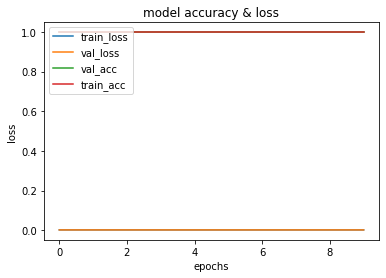

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
#plotting history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['acc'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('model accuracy & loss')
plt.legend(['train_loss', 'val_loss','val_acc','train_acc'], loc='upper left')

In [ ]:
# import os
# os.curdir

In [ ]:
#saving the model
# model.save("model")

In [ ]:
#loading the model
# model = load_model('model')

In [40]:
type(y_train)

numpy.ndarray

In [41]:
print(test_data['label'].shape)
test_label=test_data['label'].to_numpy().reshape(-1,1)
test_label.shape

(15120,)


(15120, 1)

In [44]:
# Evaluate the model on the test
print("Evaluate on test data")
results = model.evaluate([test_text1_seq_pad,test_text2_seq_pad], test_label, batch_size=64)
print("test loss, test acc:", results)

# # Generate predictions (probabilities -- the output of the last layer)
# # on new data using `predict`
# print("Generate predictions for 3 samples")
# predictions = model.predict([test_text1_seq_pad[:5],test_text2_seq_pad[:5]])
# print("predictions shape:", predictions.shape)

Evaluate on test data
15120/15120 [==============================] - 3s 173us/sample - loss: 0.0054 - acc: 0.9946
test loss, test acc: [0.005418664555269042, 0.99464285]
